# IEEE-CIS Fraud Detection

Can you detect fraud from customer transactions?

Competition: https://www.kaggle.com/c/ieee-fraud-detection

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import math

## Load data

Firstly, create function to optimize memory for loading the data

In [6]:
# From: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024 ** 2
    print("Memory usage of properties dataframe is :", start_mem_usg, " MB")
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            IsInt = False

            mx = props[col].max()
            mn = props[col].min()

            if not np.isfinite(props[col]).all():
                props[col].fillna(-999, inplace=True)

            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()

            if -0.01 < result < 0.01:
                IsInt = True

            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)
            else:
                props[col] = props[col].astype(np.float32)

    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024 ** 2
    print("Memory usage is: ", mem_usg, " MB")
    print("This is ", 100 * mem_usg / start_mem_usg, "% of the initial size")
    return props

def load_csv(path):
    return reduce_mem_usage(pd.read_csv(path))

### Load the test & train data

In [7]:
ASSETS_PATH = './assets/'
train_identity = load_csv(f'{ASSETS_PATH}/train_identity.csv')
train_transaction = load_csv(f'{ASSETS_PATH}/train_transaction.csv')
test_identity = load_csv(f'{ASSETS_PATH}/test_identity.csv')
test_transaction = load_csv(f'{ASSETS_PATH}/test_transaction.csv')

Memory usage of properties dataframe is : 45.116905212402344  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  23.934003829956055  MB
This is  53.04885988362684 % of the initial size
Memory usage of properties dataframe is : 1775.152359008789  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  450.5463409423828  MB
This is  25.38071386694713 % of the initial size
Memory usage of properties dataframe is : 44.389320373535156  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  23.54802894592285  MB
This is  53.04886118500284 % of the initial size
Memory usage of properties dataframe is : 1519.2380752563477  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  376.9102668762207  MB
This is  24.80916408131905 % of the initial size


## Visualizations

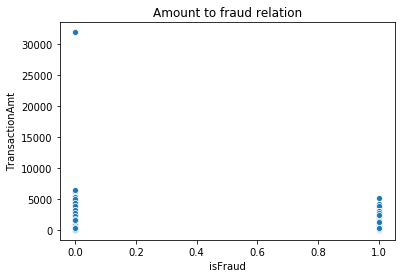

In [8]:
plt.title('Amount to fraud relation')
sns.scatterplot(x='isFraud', y='TransactionAmt', data=train_transaction)
plt.show()

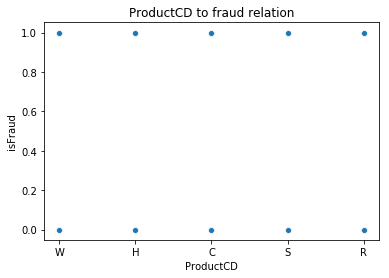

In [10]:
plt.figure()
plt.title('ProductCD to fraud relation')
sns.scatterplot(x='ProductCD', y='isFraud', data=train_transaction)
plt.show()

## Join transactions with identities

In [11]:
train_df = reduce_mem_usage(pd.merge(train_transaction, train_identity, on='TransactionID', how='left'))
test_df = reduce_mem_usage(pd.merge(test_transaction, test_identity, on='TransactionID', how='left'))

Memory usage of properties dataframe is : 633.0175018310547  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  550.7928085327148  MB
This is  87.01067615658363 % of the initial size
Memory usage of properties dataframe is : 533.4728851318359  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  462.92302894592285  MB
This is  86.77536231884058 % of the initial size


### Prepare categorical & numerical columns

**Categorical Features in Transaction**
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

**Categorical Features in Identity**
- DeviceType
- DeviceInfo
- id_12 - id_38

In [12]:
CATEGORICAL_COLS = 'id_1\d|id_2\d|id_3\d|card|ProductCD|add|email|M|DeviceType|DeviceInfo'
categorical_columns = train_df.filter(regex=CATEGORICAL_COLS).drop(columns=['id_10', 'id_11']).columns
numerical_columns = train_df.drop(columns=[*categorical_columns, 'TransactionID', 'isFraud']).columns

### Normalize numerical columns

In [13]:
train_df[numerical_columns] = train_df[numerical_columns].apply(lambda df: (df - df.min()) / (df.max() - df.min()))

### Encode categorical data

Based on idea from: https://www.kaggle.com/c/ieee-fraud-detection/discussion/108575#latest-627291

In [14]:
for column in categorical_columns:
    column_df = pd.concat([train_df[column], test_df[column]])
    column_df, _ = column_df.factorize()

    if column_df.max() < 128:
        column_df = column_df.astype('int8')
    elif column_df.max() < 32768:
        column_df = column_df.astype('int16')
    else:
        column_df.astype('int32')

    train_df[column] = column_df[:len(train_df)]
    test_df[column] = column_df[len(train_df):]

### Split train df to X and y

In [15]:
train_df_X = train_df.drop(columns=['isFraud'])
train_df_y = train_df['isFraud']
train_X, test_X, train_y, test_y = train_test_split(train_df_X, train_df_y, test_size=.2)

### Logistic regression model

Definition & training

In [16]:
lr_model = LogisticRegression(solver='saga', max_iter=150, n_jobs=8, verbose=1)
lr_model.fit(train_X, train_y)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


max_iter reached after 353 seconds


/home/simon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:  5.9min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=150, multi_class='warn', n_jobs=8,
          penalty='l2', random_state=None, solver='saga', tol=0.0001,
          verbose=1, warm_start=False)

### Predict frauds

In [17]:
test_predictions = lr_model.predict(test_X)
predictions = lr_model.predict_proba(test_df)

### Display statistics

In [19]:
print('Test ROC AUC: ', roc_auc_score(test_y, test_predictions))
print('Test RMSE: ', math.sqrt(mean_squared_error(test_y, test_predictions)))
print('Score (Mean Accuracy): ', lr_model.score(test_X, test_y))

Test ROC AUC:  0.5
Test RMSE:  0.1865666789155544
Score (Mean Accuracy):  0.9651928743184204
